In [151]:
from scipy.fftpack import fft
from scipy.stats import linregress
import numpy as np

def compute_total_power(time_series):
    time_series = time_series.to_numpy()  # 👈 convert to numpy array
    n = len(time_series)
    fft_vals = fft(time_series)
    power_spectrum = np.abs(fft_vals[:n // 2])**2
    total_power = np.sum(power_spectrum)
    return total_power

def compute_power_law_slope(time_series, fs=1.0):
    time_series = time_series.to_numpy()  # 👈 convert to numpy array
    n = len(time_series)
    freqs = np.fft.fftfreq(n, d=1/fs)[:n // 2]
    fft_vals = fft(time_series)
    power = np.abs(fft_vals[:n // 2]) ** 2

    valid = freqs > 0
    log_freqs = np.log10(freqs[valid])
    log_power = np.log10(power[valid])

    slope, _, _, _, _ = linregress(log_freqs, log_power)
    return slope


In [152]:
import os

In [153]:
root_dir = "/scratch/data/90000189/BIDS/derivatives/fmriprep/def-plus/ts/scha17-1"
data_no_gsr_dir = "/scratch/data/90000189/BIDS/derivatives/fmriprep/def-plus/ts/scha17-1/simple-gsr_lp-0.09_fwhm-6"
data_with_gsr_dir = "/scratch/data/90000189/BIDS/derivatives/fmriprep/def-plus/ts/scha17-1/simple_lp-0.09_fwhm-6"

In [154]:
sessions = ['mec01', 'mec02', 'mec03', 'mec04', 'mec05', 'msl01', 'msl02', 'msl03', 'msl04', 'msl05', 'msl06']

In [155]:
os.path.isdir(root_dir)
os.listdir(root_dir)[:]


['simple-gsr_lp-0.09_fwhm-6', 'simple_lp-0.09_fwhm-6']

In [156]:
mrs_data_dir = "/data_downloads/MRS-data_from-benali"
os.path.isdir(mrs_data_dir)
os.listdir(mrs_data_dir)[:]

['PCC_new.mat', 'SD.mat', '__MACOSX', 'SMA_new.mat']

In [157]:
import scipy.io as sio
pcc_mrs_mat = sio.loadmat(os.path.join(mrs_data_dir,'PCC_new.mat'))
pcc_mrs = pcc_mrs_mat['PCC']

sma_mrs_mat = sio.loadmat(os.path.join(mrs_data_dir,'SMA_new.mat'))
sma_mrs = sma_mrs_mat['SMA']

pcc_mrs

array([[15.29 , 15.55 , 15.62 , 16.51 , 15.88 , 14.98 , 15.46 , 16.1  ,
        15.03 , 15.05 , 15.97 ],
       [15.43 , 14.   , 13.5  , 13.62 , 11.92 ,  9.127, 10.75 , 11.03 ,
           nan,  9.414,  7.814],
       [ 4.799, 14.6  , 11.11 , 13.78 , 13.25 , 14.64 , 13.27 , 14.93 ,
        13.42 , 14.1  , 15.61 ],
       [ 8.984, 10.63 , 13.62 ,    nan,    nan,  5.614, 14.38 , 14.42 ,
        14.83 , 15.02 , 15.33 ],
       [16.09 , 15.25 , 15.41 , 15.5  , 14.49 , 14.89 , 15.19 , 14.15 ,
        15.13 , 15.55 , 14.07 ],
       [12.32 , 14.76 , 13.98 , 13.91 , 12.51 , 11.2  , 14.31 , 13.58 ,
        15.14 , 14.5  , 12.17 ]])

In [158]:
file_path = os.path.join(data_no_gsr_dir, 'labels.txt')  

try:
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    processed_lines = [line.strip() for line in lines]
    

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
    
print(len(processed_lines))

100


In [159]:
target_rois =target_rois = [
    "17Networks_LH_DefaultA_pCunPCC_1",
    "17Networks_RH_DefaultA_pCunPCC_1",
    "17Networks_LH_SomMotA_1",
    "17Networks_LH_SomMotA_2",
    "17Networks_RH_SomMotA_1",
    "17Networks_RH_SomMotA_2",
    "17Networks_RH_SomMotA_3",
    "17Networks_RH_SomMotA_4",
    "17Networks_LH_DorsAttnB_PostC_1",
    "17Networks_LH_DorsAttnB_PostC_2",
    "17Networks_LH_DorsAttnB_PostC_3",
    "17Networks_RH_DorsAttnB_PostC_1",
    "17Networks_RH_DorsAttnB_PostC_2"
]


target_rois_pcc= [
    "17Networks_LH_DefaultA_pCunPCC_1",
    "17Networks_RH_DefaultA_pCunPCC_1",
]

target_rois_sma =[
    "17Networks_LH_SomMotA_1",
    "17Networks_LH_SomMotA_2",
    "17Networks_RH_SomMotA_1",
    "17Networks_RH_SomMotA_2",
    "17Networks_RH_SomMotA_3",
    "17Networks_RH_SomMotA_4",
]

In [160]:
results=[]
for path in [(data_no_gsr_dir,'no gsr'),(data_with_gsr_dir,'with gsr')]:
    data_dir = path[0]
    for sub in range (2,8):
        sub_id = f"sub-{sub:02d}"
        for sess in sessions:
            filename = f"{sub_id}_ses-{sess}.csv"
            file_path = os.path.join(data_dir, filename)

            df = pd.read_csv(file_path)
            df.columns = processed_lines

            roi_df = df[target_rois]
            for roi in roi_df.columns:
                time_points = roi_df[roi]
                mean_val = np.mean(time_points)
                var_val = np.var(time_points)
                total_power = compute_total_power(time_points)
                slope = compute_power_law_slope(time_points)

                pcc_mrs_val = pcc_mrs[sub-2,sessions.index(sess)]
                sma_mrs_val = sma_mrs[sub-2,sessions.index(sess)]

                results.append({
                    "subject": sub_id,
                    "session": sess,
                    "roi": roi,
                    "gsr": path[1],
                    "mean": mean_val,
                    "variance": var_val,
                    "total power": total_power,
                    "power law slope": slope,
                    "pcc mrs": pcc_mrs_val,
                    "sma mrs": sma_mrs_val
                })


In [161]:
import pandas as pd
df_results = pd.DataFrame(results)
df_results.to_csv("fmri_features_with_mrs.csv", index=False)
df_results.head(20)

subject session                               roi     gsr         mean  \
0   sub-02   mec01  17Networks_LH_DefaultA_pCunPCC_1  no gsr  1384.084756   
1   sub-02   mec01  17Networks_RH_DefaultA_pCunPCC_1  no gsr  1342.522984   
2   sub-02   mec01           17Networks_LH_SomMotA_1  no gsr  1528.789775   
3   sub-02   mec01           17Networks_LH_SomMotA_2  no gsr  1581.240097   
4   sub-02   mec01           17Networks_RH_SomMotA_1  no gsr  2005.650420   
5   sub-02   mec01           17Networks_RH_SomMotA_2  no gsr  1836.775335   
6   sub-02   mec01           17Networks_RH_SomMotA_3  no gsr  1960.331775   
7   sub-02   mec01           17Networks_RH_SomMotA_4  no gsr  1626.188157   
8   sub-02   mec01   17Networks_LH_DorsAttnB_PostC_1  no gsr  1573.530713   
9   sub-02   mec01   17Networks_LH_DorsAttnB_PostC_2  no gsr  1579.217498   
10  sub-02   mec01   17Networks_LH_DorsAttnB_PostC_3  no gsr  1852.152380   
11  sub-02   mec01   17Networks_RH_DorsAttnB_PostC_1  no gsr  1866.142431   
12  sub-02   mec01   17Networks_RH_DorsAttnB_PostC_2  no gsr  1866.326274   
13  sub-02   mec02  17Networks_LH_DefaultA_pCunPCC_1  no gsr  1222.538986   
14  sub-02   mec02  17Networks_RH_DefaultA_pCunPCC_1  no gsr  1183.875319   
15  sub-02   mec02           17Networks_LH_SomMotA_1  no gsr  1262.778270   
16  sub-02   mec02           17Networks_LH_SomMotA_2  no gsr  1334.303063   
17  sub-02   mec02           17Networks_RH_SomMotA_1  no gsr  1608.236701   
18  sub-02   mec02           17Networks_RH_SomMotA_2  no gsr  1432.459229   
19  sub-02   mec02           17Networks_RH_SomMotA_3  no gsr  1539.004764   

     variance   total power  power law slope  pcc mrs  sma mrs  
0   11.052421  2.098856e+11        -2.357474    15.29    11.45  
1   13.479230  1.974700e+11        -3.906936    15.29    11.45  
2    5.029322  2.560660e+11        -2.895188    15.29    11.45  
3    2.665821  2.739377e+11        -1.724240    15.29    11.45  
4    6.425380  4.407241e+11        -3.818444    15.29    11.45  
5   12.601335  3.696314e+11        -2.649912    15.29    11.45  
6   10.512133  4.210326e+11        -3.302108    15.29    11.45  
7    8.189927  2.897332e+11        -1.797595    15.29    11.45  
8    8.313466  2.712734e+11        -2.915348    15.29    11.45  
9    6.310758  2.732376e+11        -2.081744    15.29    11.45  
10  12.689885  3.758462e+11        -2.178659    15.29    11.45  
11   5.663419  3.815451e+11        -1.852926    15.29    11.45  
12  23.361598  3.816213e+11        -1.614528    15.29    11.45  
13   5.526768  1.637503e+11        -1.914220    15.55    14.36  
14   8.739701  1.535569e+11        -1.882156    15.55    14.36  
15   1.001798  1.747070e+11        -3.051989    15.55    14.36  
16   1.055057  1.950586e+11        -2.435744    15.55    14.36  
17   2.754716  2.833715e+11        -3.182140    15.55    14.36  
18   3.009571  2.248127e+11        -3.301378    15.55    14.36  
19   3.532970  2.594993e+11        -3.308080    15.55    14.36

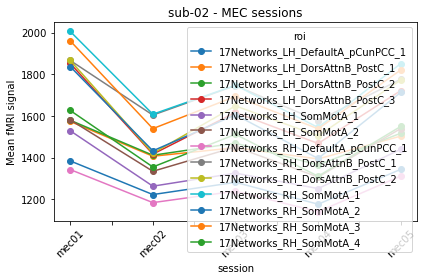

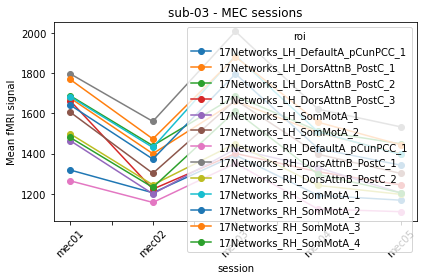

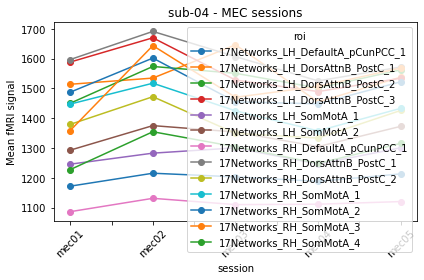

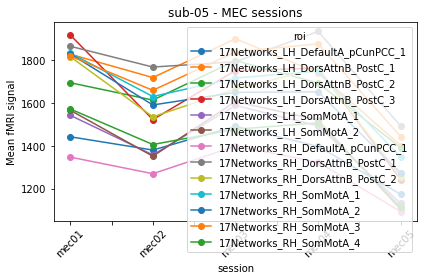

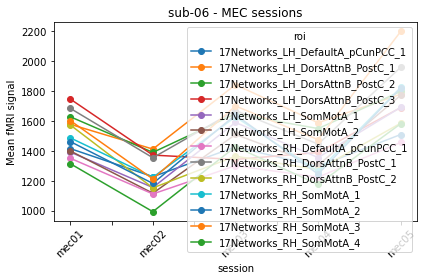

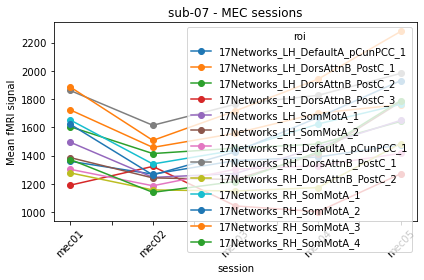

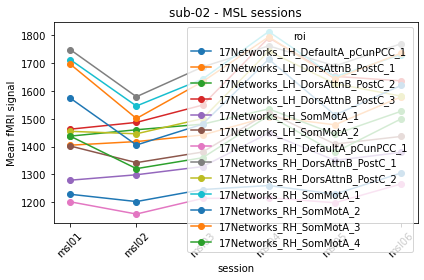

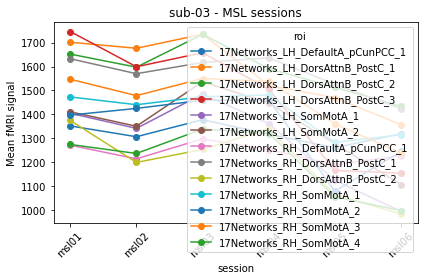

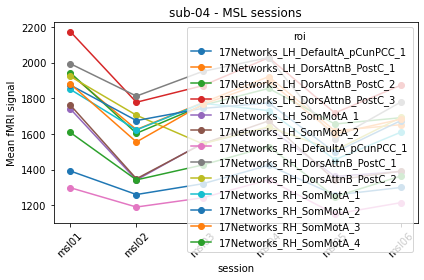

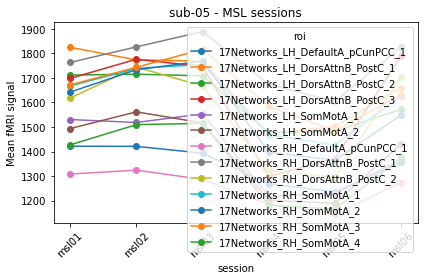

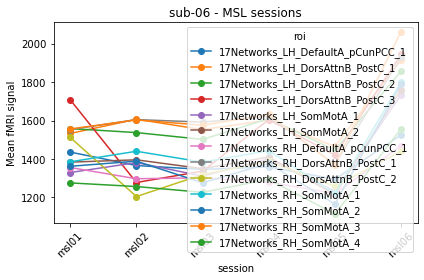

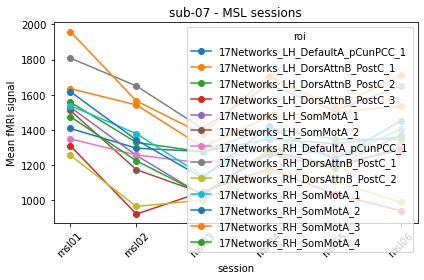

In [166]:
import matplotlib.pyplot as plt

# Filter to only use "no gsr" data
df_no_gsr = df_results[df_results["gsr"] == "no gsr"]

# Separate into mec and msl sessions
mec_sessions = [f"mec0{i}" for i in range(1, 6)]
msl_sessions = [f"msl0{i}" for i in range(1, 7)]

# Get all unique subjects
subjects = df_no_gsr["subject"].unique()

# Create one plot per subject for MEC sessions
for sub in subjects:
    sub_df = df_no_gsr[(df_no_gsr["subject"] == sub) & (df_no_gsr["session"].isin(mec_sessions))]
    if not sub_df.empty:
        pivot_df = sub_df.pivot(index="session", columns="roi", values="mean").reindex(mec_sessions)
        pivot_df.plot(marker='o', title=f"{sub} - MEC sessions", ylabel="Mean fMRI signal")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Create one plot per subject for MSL sessions
for sub in subjects:
    sub_df = df_no_gsr[(df_no_gsr["subject"] == sub) & (df_no_gsr["session"].isin(msl_sessions))]
    if not sub_df.empty:
        pivot_df = sub_df.pivot(index="session", columns="roi", values="mean").reindex(msl_sessions)
        pivot_df.plot(marker='o', title=f"{sub} - MSL sessions", ylabel="Mean fMRI signal")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


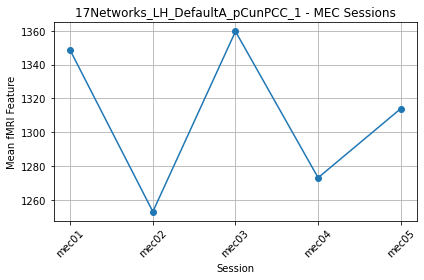

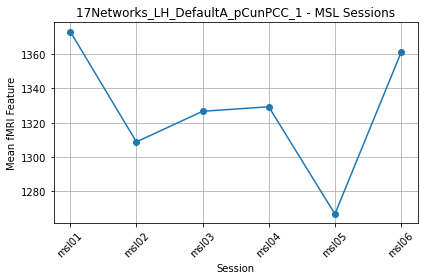

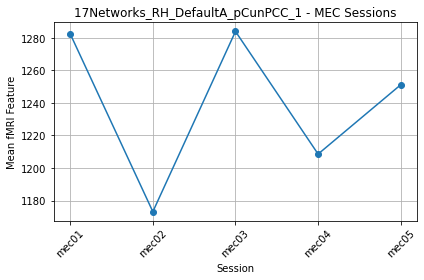

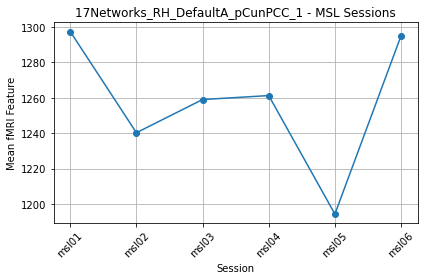

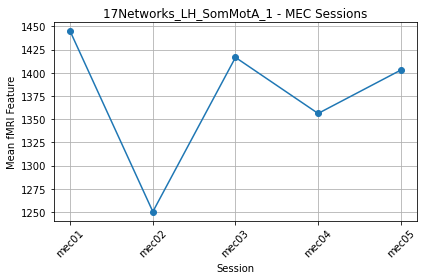

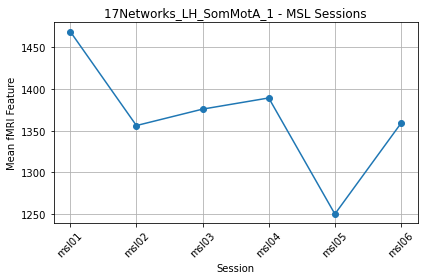

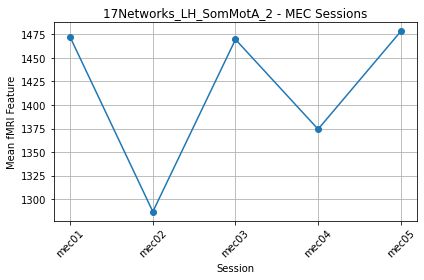

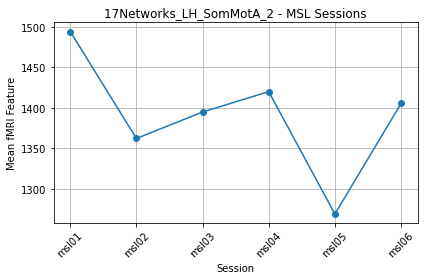

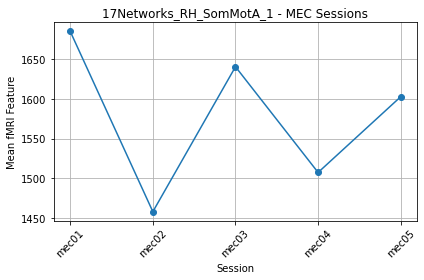

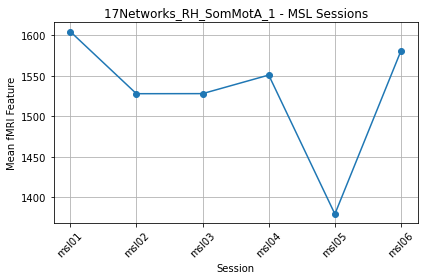

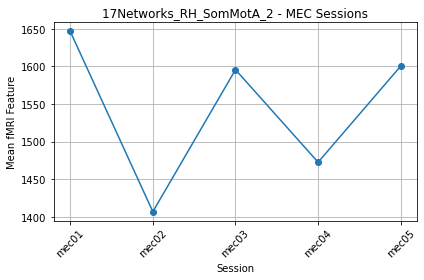

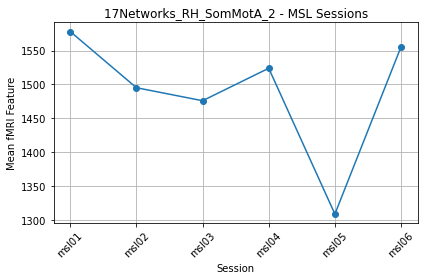

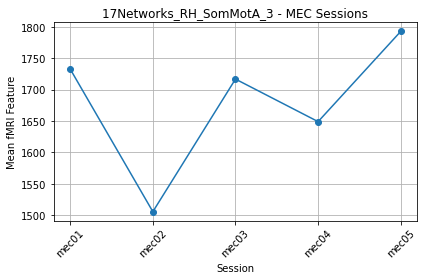

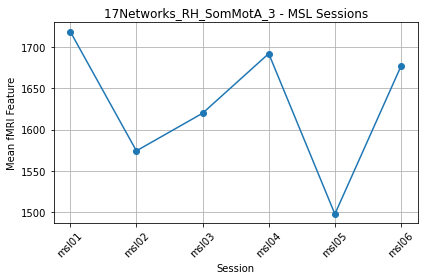

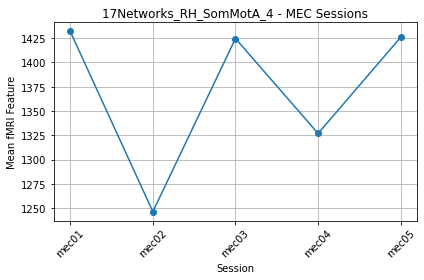

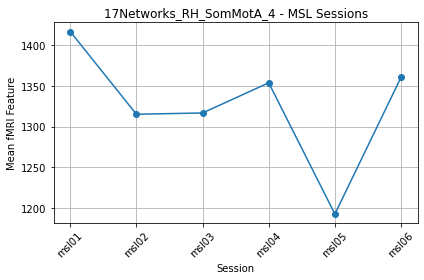

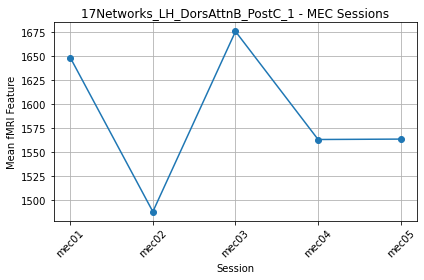

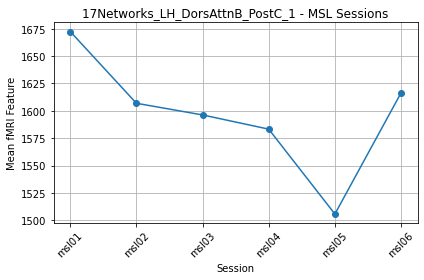

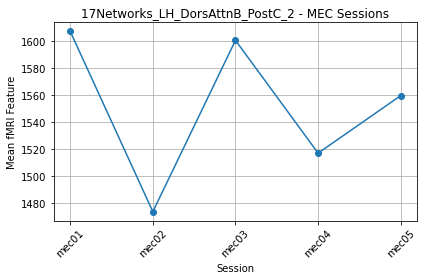

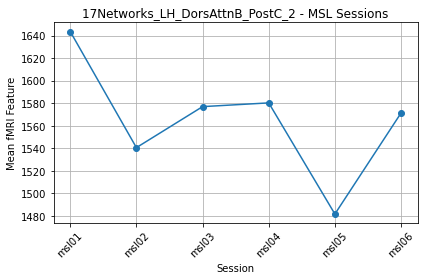

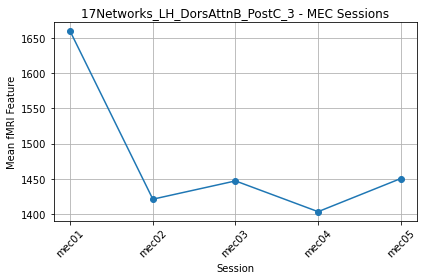

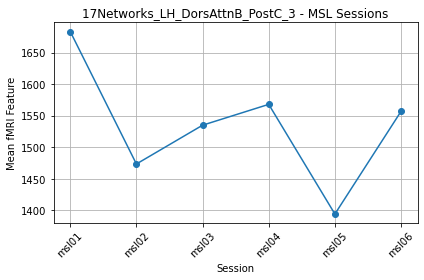

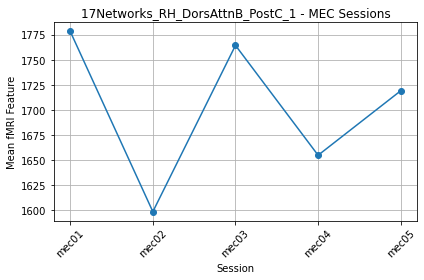

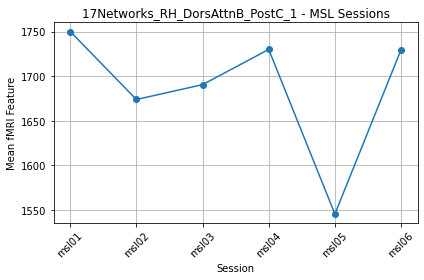

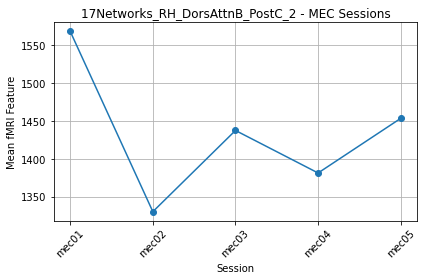

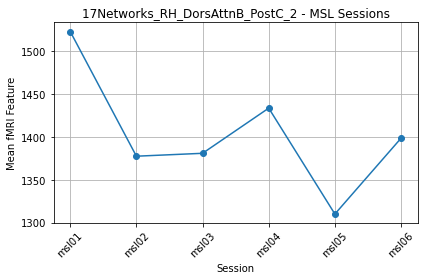

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results DataFrame from the uploaded file
file_path = "/mnt/data/fmri_features_with_mrs(1).csv"
df = df_results

# Filter only "no gsr" data
df_no_gsr = df[df["gsr"] == "no gsr"]

# Extract session types
mec_sessions = [s for s in df_no_gsr["session"].unique() if s.startswith("mec")]
msl_sessions = [s for s in df_no_gsr["session"].unique() if s.startswith("msl")]

# Sort sessions properly
mec_sessions = sorted(mec_sessions, key=lambda x: int(x[-2:]))
msl_sessions = sorted(msl_sessions, key=lambda x: int(x[-2:]))

# Get list of ROIs
rois = df_no_gsr["roi"].unique()

# Generate plots
for roi in rois:
    # MEC sessions
    df_mec = df_no_gsr[(df_no_gsr["roi"] == roi) & (df_no_gsr["session"].isin(mec_sessions))]
    mean_per_mec_session = df_mec.groupby("session")["mean"].mean().reindex(mec_sessions)

    plt.figure()
    plt.plot(mean_per_mec_session.index, mean_per_mec_session.values, marker="o")
    plt.title(f"{roi} - MEC Sessions")
    plt.xlabel("Session")
    plt.ylabel("Mean fMRI Feature")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # MSL sessions
    df_msl = df_no_gsr[(df_no_gsr["roi"] == roi) & (df_no_gsr["session"].isin(msl_sessions))]
    mean_per_msl_session = df_msl.groupby("session")["mean"].mean().reindex(msl_sessions)

    plt.figure()
    plt.plot(mean_per_msl_session.index, mean_per_msl_session.values, marker="o")
    plt.title(f"{roi} - MSL Sessions")
    plt.xlabel("Session")
    plt.ylabel("Mean fMRI Feature")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


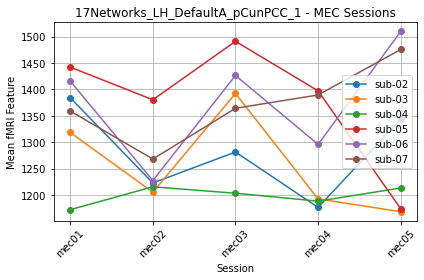

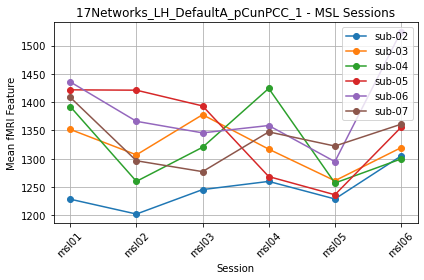

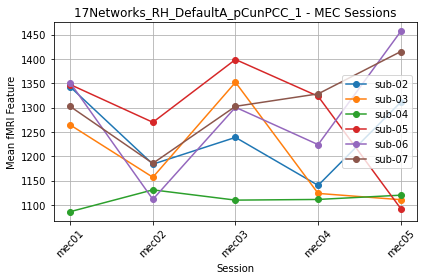

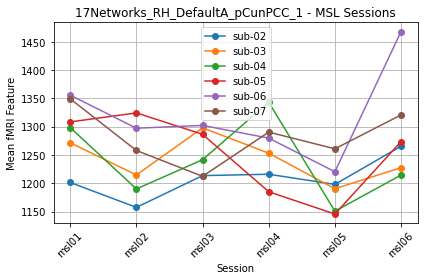

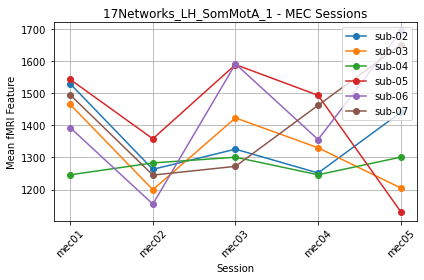

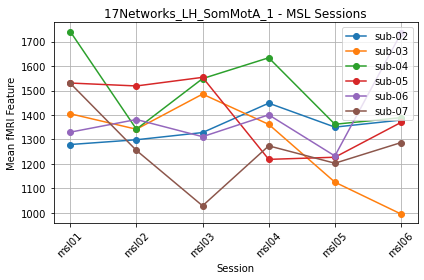

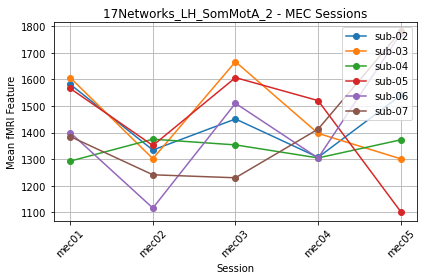

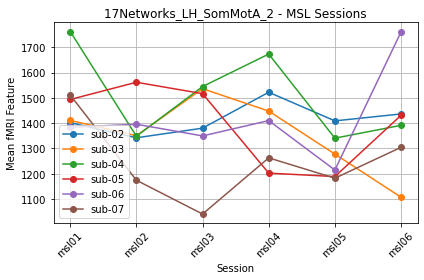

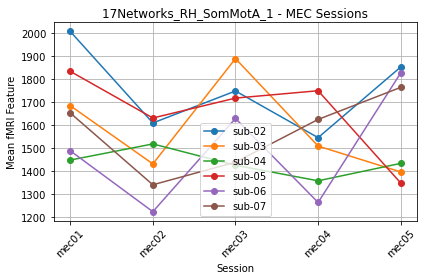

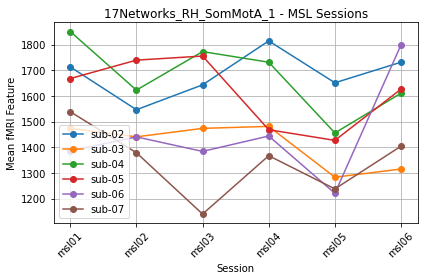

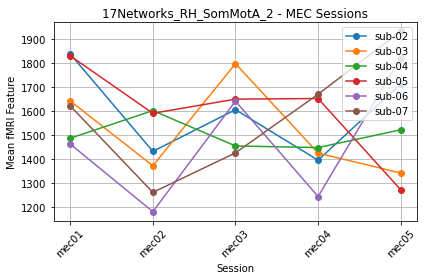

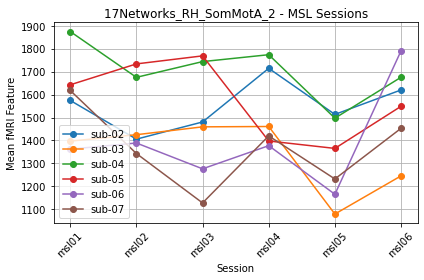

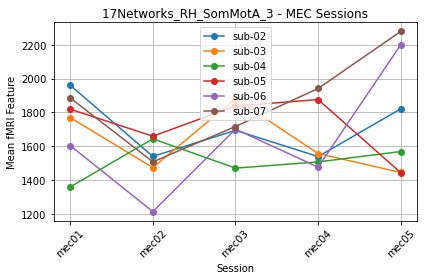

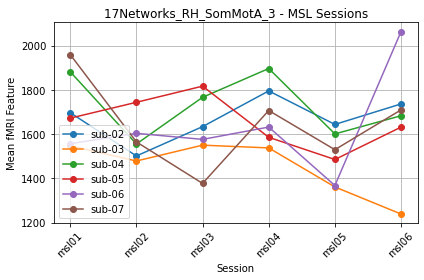

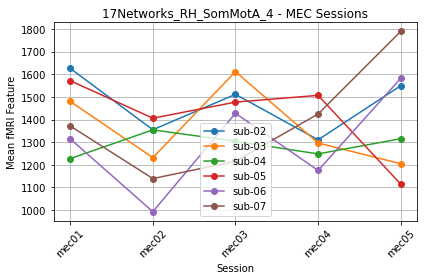

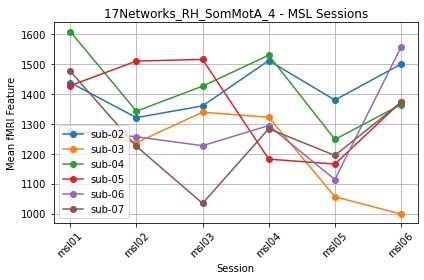

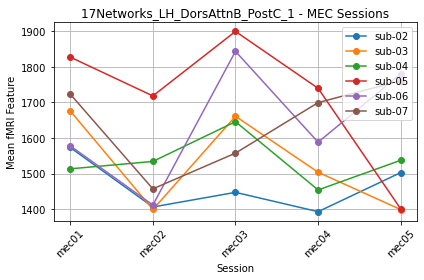

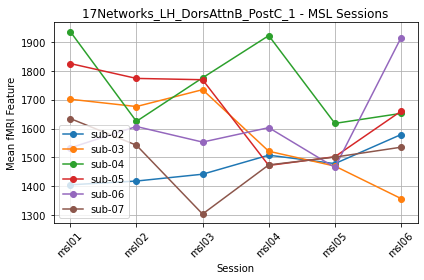

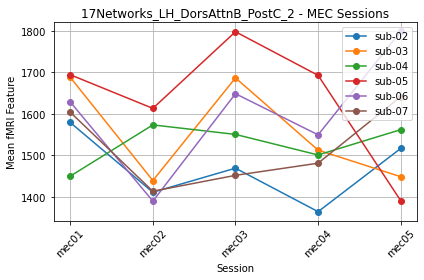

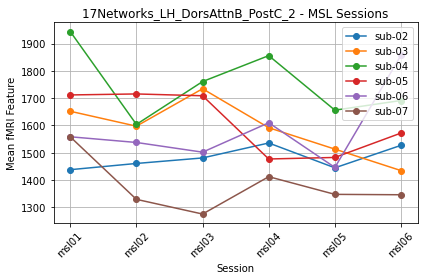

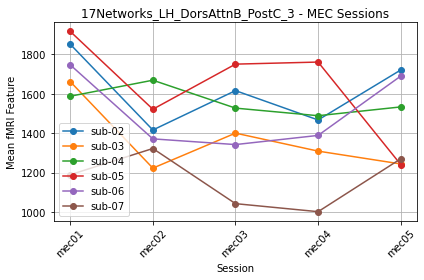

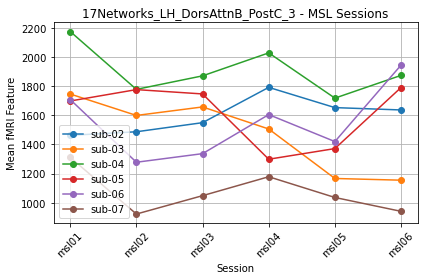

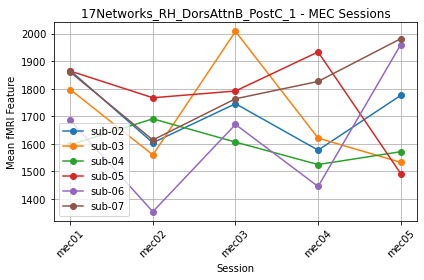

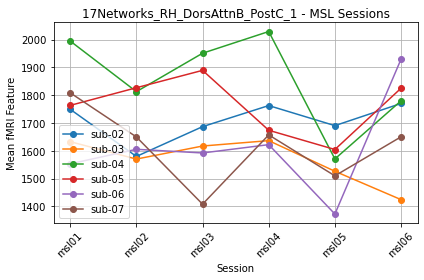

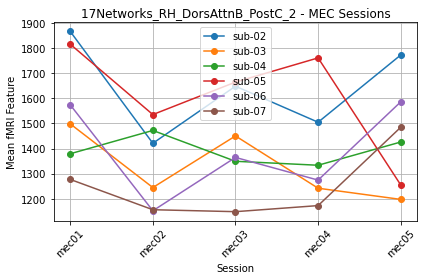

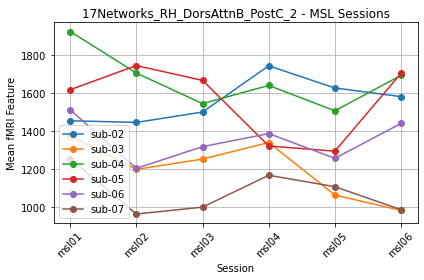

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

df = df = df_results
df_no_gsr = df[df["gsr"] == "no gsr"]

mec_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("mec")], key=lambda x: int(x[-2:]))
msl_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("msl")], key=lambda x: int(x[-2:]))

rois = df_no_gsr["roi"].unique()
subjects = sorted(df_no_gsr["subject"].unique())

for roi in rois:
    # MEC session plot
    plt.figure()
    for subj in subjects:
        subj_data = df_no_gsr[(df_no_gsr["roi"] == roi) & (df_no_gsr["subject"] == subj) & (df_no_gsr["session"].isin(mec_sessions))]
        subj_data = subj_data.set_index("session").reindex(mec_sessions)
        plt.plot(subj_data.index, subj_data["mean"], marker="o", label=subj)
    plt.title(f"{roi} - MEC Sessions")
    plt.xlabel("Session")
    plt.ylabel("Mean fMRI Feature")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # MSL session plot
    plt.figure()
    for subj in subjects:
        subj_data = df_no_gsr[(df_no_gsr["roi"] == roi) & (df_no_gsr["subject"] == subj) & (df_no_gsr["session"].isin(msl_sessions))]
        subj_data = subj_data.set_index("session").reindex(msl_sessions)
        plt.plot(subj_data.index, subj_data["mean"], marker="o", label=subj)
    plt.title(f"{roi} - MSL Sessions")
    plt.xlabel("Session")
    plt.ylabel("Mean fMRI Feature")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


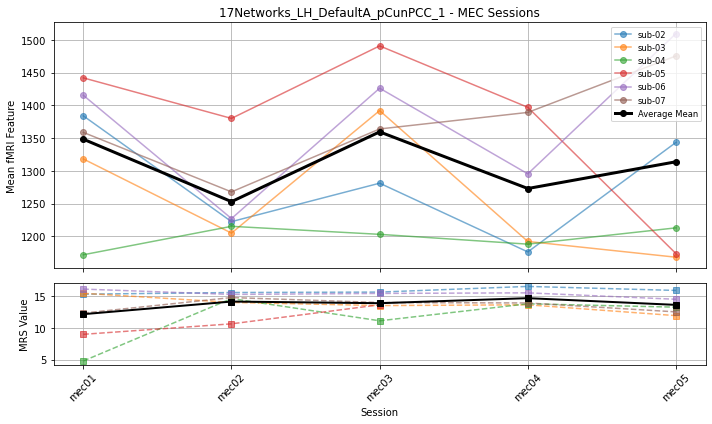

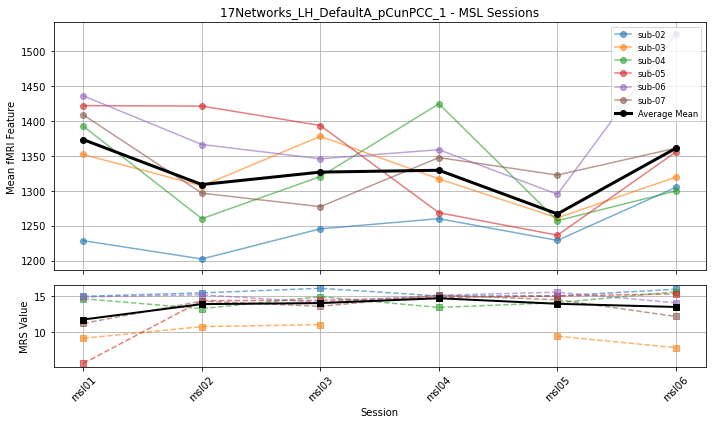

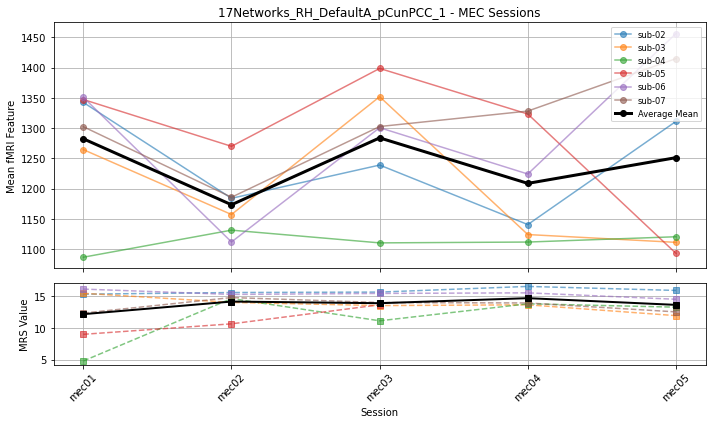

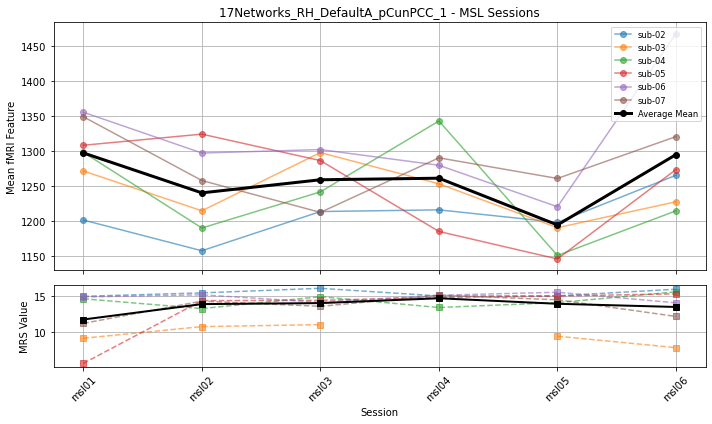

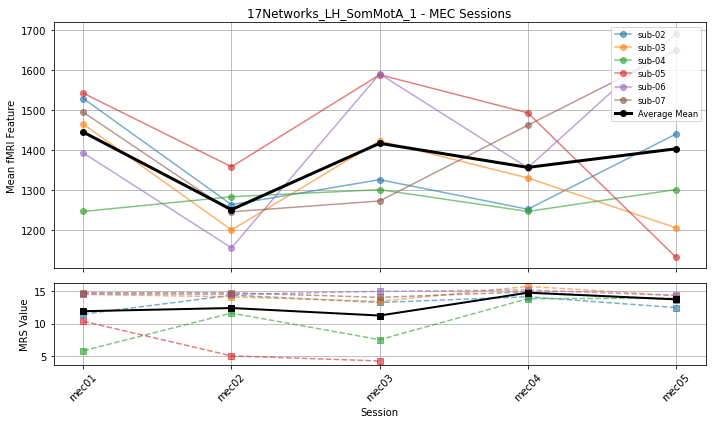

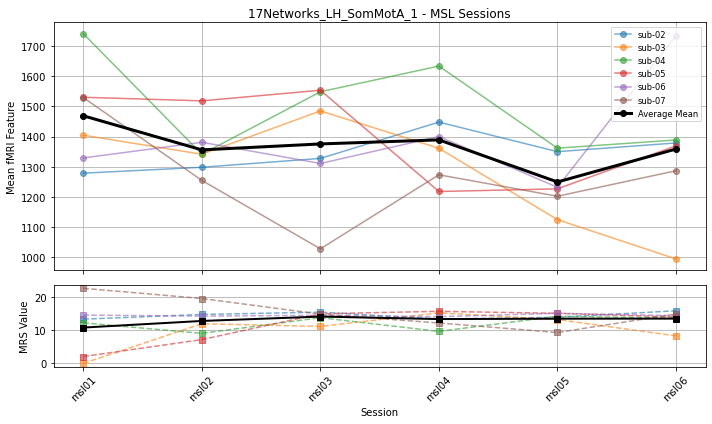

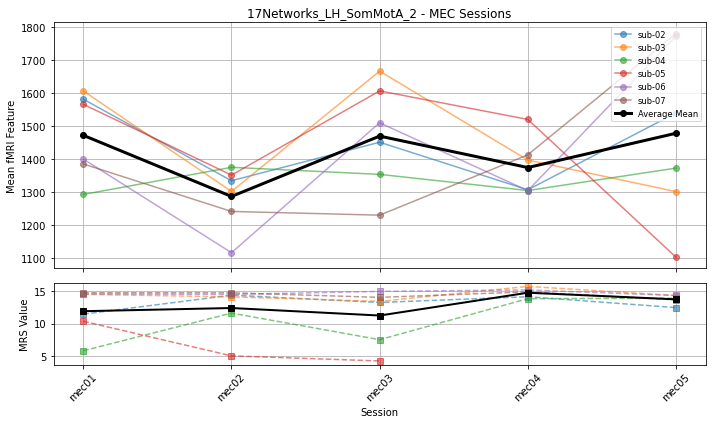

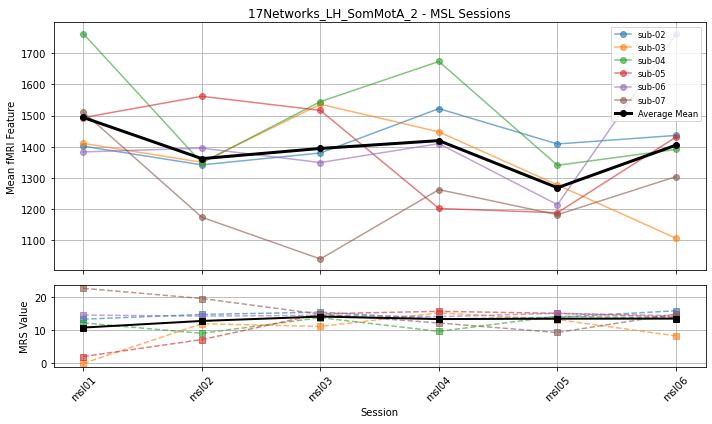

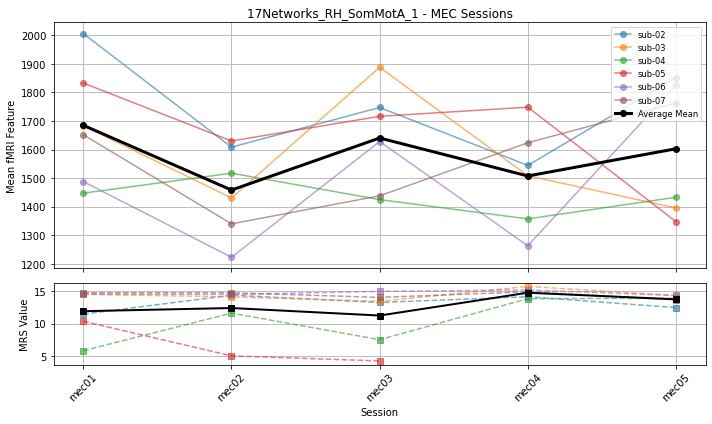

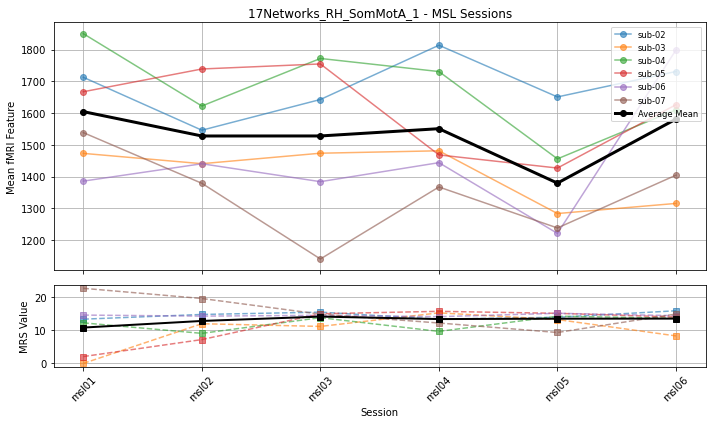

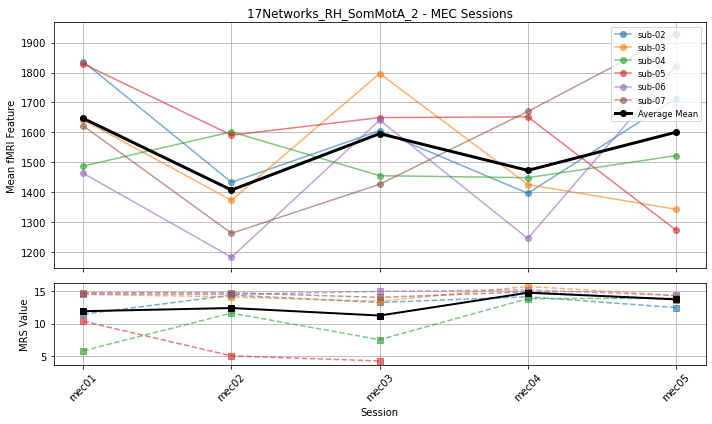

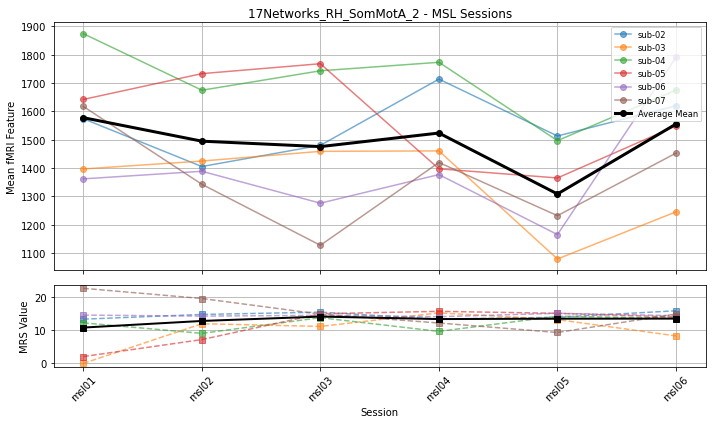

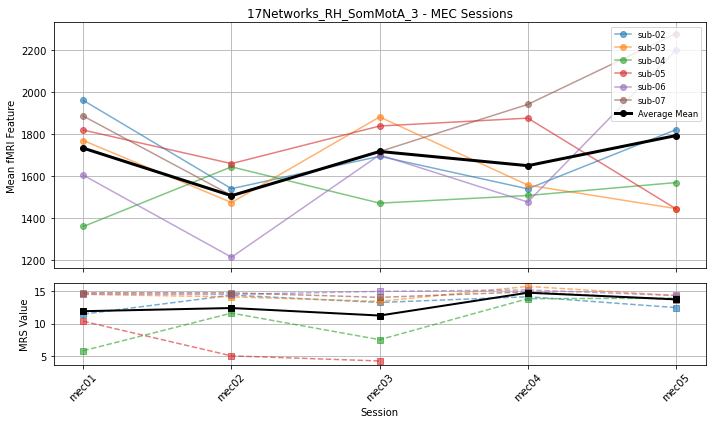

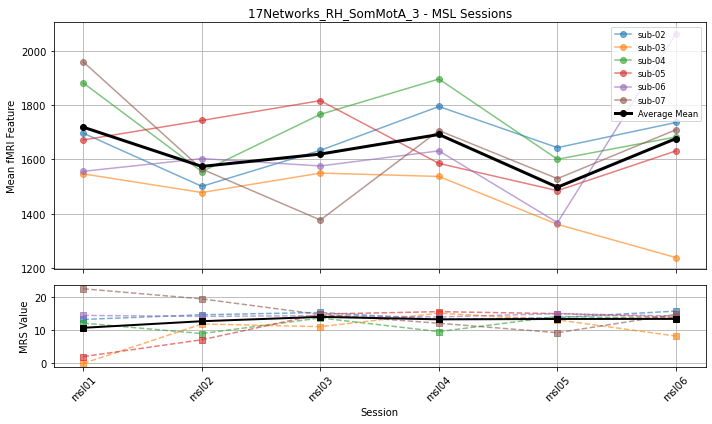

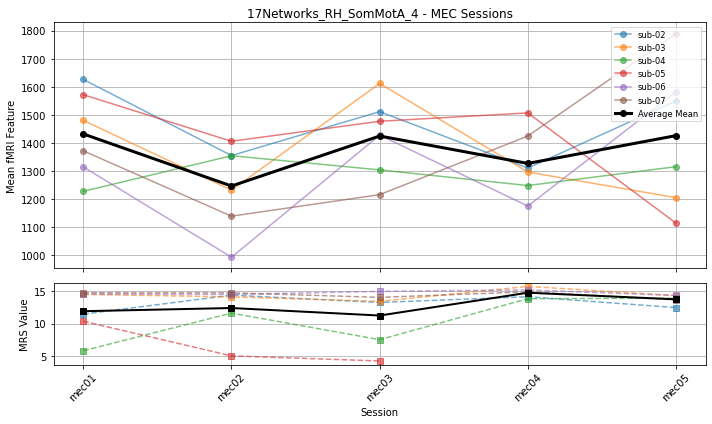

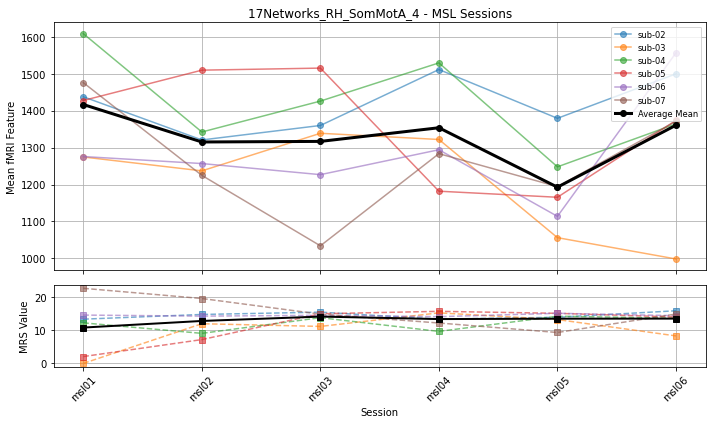

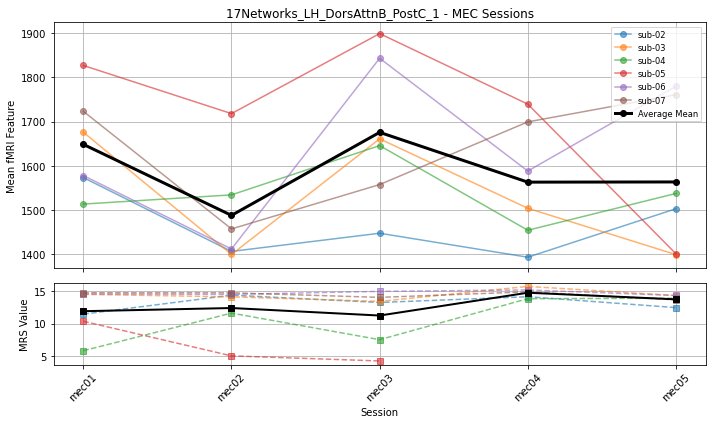

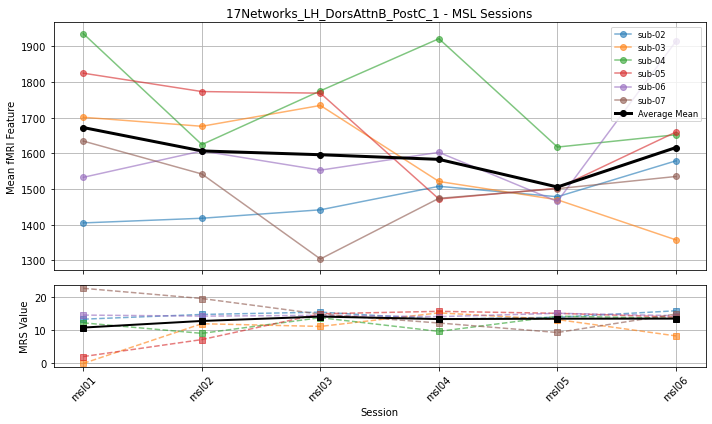

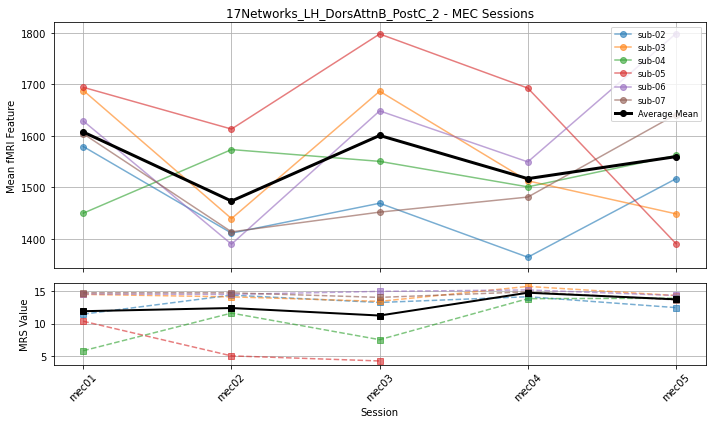

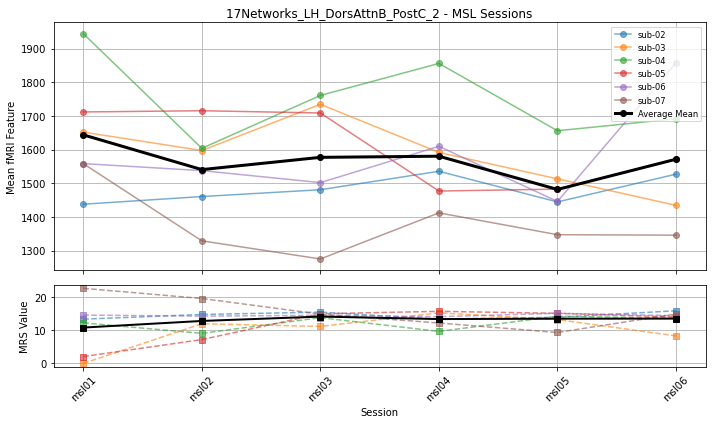

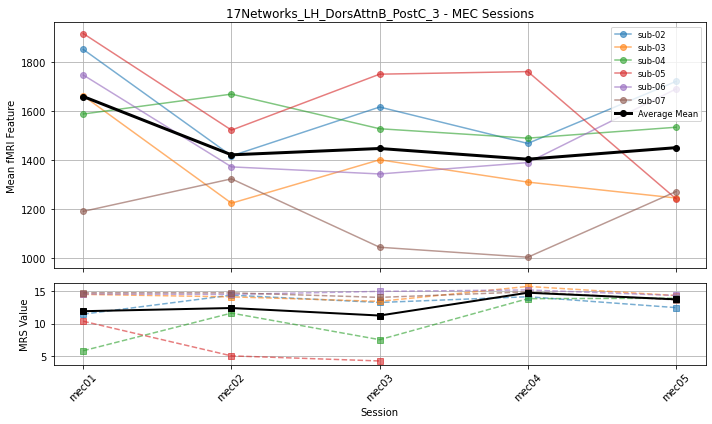

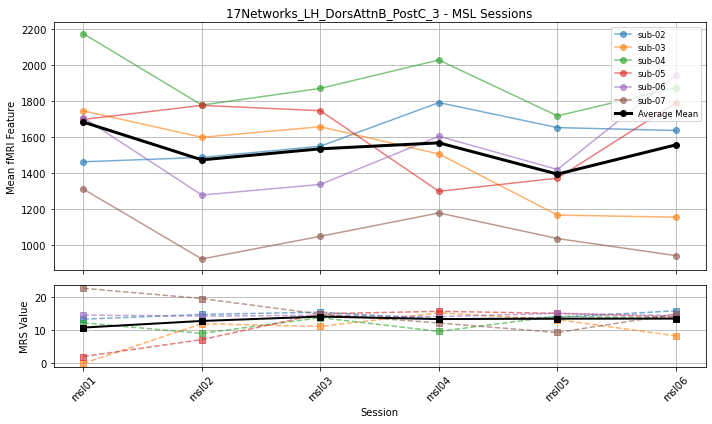

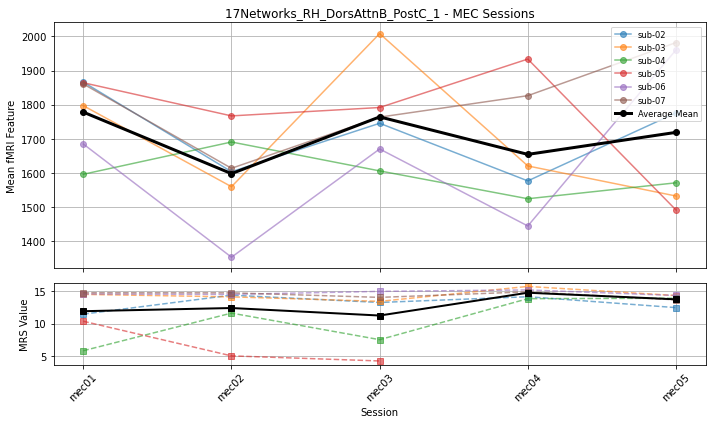

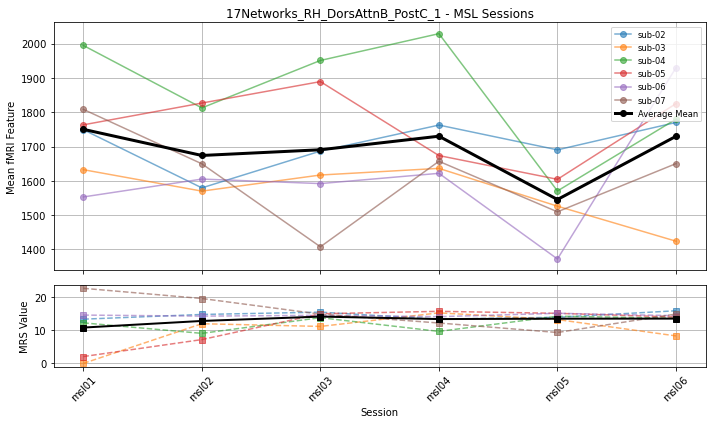

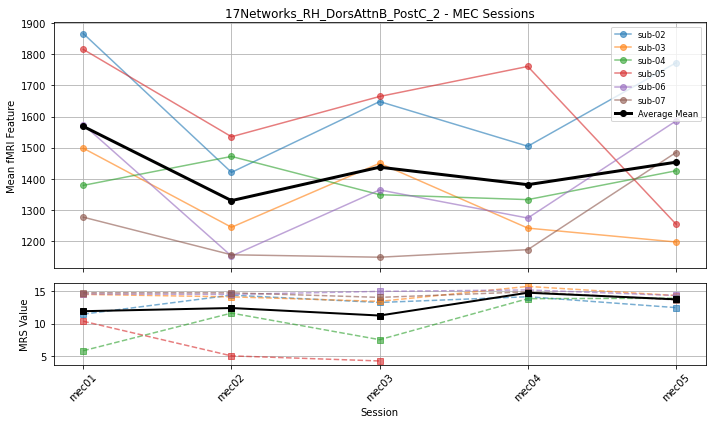

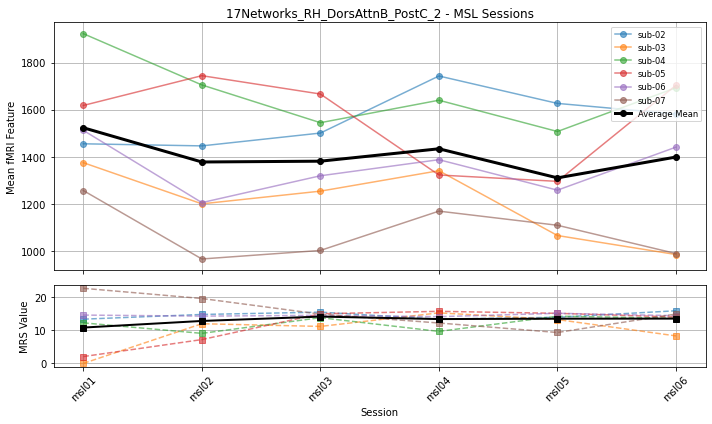

In [177]:
# Re-import necessary modules after kernel reset
import pandas as pd
import matplotlib.pyplot as plt


df = df_results

# Filter to 'no gsr' data only
df_no_gsr = df[df["gsr"] == "no gsr"]

# Define session groupings
mec_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("mec")], key=lambda x: int(x[-2:]))
msl_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("msl")], key=lambda x: int(x[-2:]))

# Define ROI list and subjects
rois = df_no_gsr["roi"].unique()
subjects = sorted(df_no_gsr["subject"].unique())

# Helper to determine MRS region
def get_mrs_column(roi_name):
    if "DefaultA_pCunPCC" in roi_name:
        return "pcc mrs"
    else:
        return "sma mrs"

# Plot: 2x13 stacked plots
for roi in rois:
    mrs_col = get_mrs_column(roi)

    for sess_group, sess_name in zip([mec_sessions, msl_sessions], ["MEC", "MSL"]):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [3, 1]})

        mean_lines = []
        mrs_lines = []

        for subj in subjects:
            subj_data = df_no_gsr[(df_no_gsr["roi"] == roi) &
                                  (df_no_gsr["subject"] == subj) &
                                  (df_no_gsr["session"].isin(sess_group))]

            subj_data = subj_data.set_index("session").reindex(sess_group)

            ax1.plot(subj_data.index, subj_data["mean"], marker="o", label=subj, alpha=0.6)
            ax2.plot(subj_data.index, subj_data[mrs_col], marker="s", linestyle="--", alpha=0.6)

            mean_lines.append(subj_data["mean"].values)
            mrs_lines.append(subj_data[mrs_col].values)

        # Plot average across subjects
        mean_avg = pd.DataFrame(mean_lines, columns=sess_group).mean(axis=0)
        mrs_avg = pd.DataFrame(mrs_lines, columns=sess_group).mean(axis=0)

        ax1.plot(sess_group, mean_avg, marker='o', linewidth=3, color='black', label='Average Mean')
        ax2.plot(sess_group, mrs_avg, marker='s', linewidth=2, color='black', label='Average MRS')

        ax1.set_ylabel("Mean fMRI Feature")
        ax2.set_ylabel("MRS Value")
        ax2.set_xlabel("Session")
        ax1.set_title(f"{roi} - {sess_name} Sessions")

        ax1.legend(loc="upper right", fontsize="small")
        ax1.grid(True)
        ax2.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
